In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import json
import numpy as np
import torch
import hydra
import scipy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import wandb
from tqdm import tqdm, trange
from src.plot_utils import scatter_plot_2d
from src.utils import sparsity_measure
from omegaconf import OmegaConf
from torchvision.utils import make_grid
from pprint import pprint
from torch.utils.data import TensorDataset, DataLoader
from pathlib import Path
from datetime import datetime
from sklearn.decomposition import MiniBatchDictionaryLearning, SparseCoder, DictionaryLearning
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans

In [4]:
sns.set_theme()
sns.set_context("paper", font_scale=1.0, rc={"text.usetex": True})
sns.set_palette("colorblind")
sns.set_style({"font.family": "serif", "font.serif": ["Times New Roman"]})

In [5]:
project_dir = Path('/n/home13/shubham/Current Projects/bioplausible_learning/code')

In [6]:
with hydra.initialize(version_base=None, config_path="../../../configs"):
    cfg = hydra.compose(config_name='ksm_mnist.yaml')
    exp_params = OmegaConf.to_container(cfg, resolve=True)
    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

exp_params['device'] = 'device'

# figfolder = Path(f'../../results/simulated/highdim/{datetime.now().strftime("%m-%d")}/{datetime.now().strftime("%H-%M")}')
# os.makedirs(figfolder, exist_ok=True)    
pprint(exp_params)    

{'dataset': {'batch_size': 128,
             'class_list': [0, 3, 4, 6, 7],
             'dim': 30,
             'fraction': 0.1,
             'n_samples': 1500,
             'name': 'mnist'},
 'device': 'device',
 'model': {'K': 400,
           'Winit': 'Kmeans',
           'lam': 0.1,
           'omega': 0.0001,
           'perturbation': 0.1,
           'rho': 1.0,
           'sparsity': 0.125},
 'optimizer': {'Minit': 'zero',
               'latent_iters': 15,
               'log_interval': 5,
               'lrs': {'Z': 0.01,
                       'Z_decay': 0.9,
                       'interval': 10,
                       'params': 0.01},
               'max_epochs': 3000,
               'param_iters': 1,
               'vis_interval': 20}}


Load mnist data

In [7]:
class_list = exp_params['dataset']['class_list']

In [8]:
from src.datasets import get_mnist_dataset
data_path = Path.cwd().parents[2]/'data'/'data_cache'
X, y, *_ = get_mnist_dataset(class_list=exp_params['dataset']['class_list'], 
                            fraction=exp_params['dataset']['fraction'],
                            datadir=data_path)


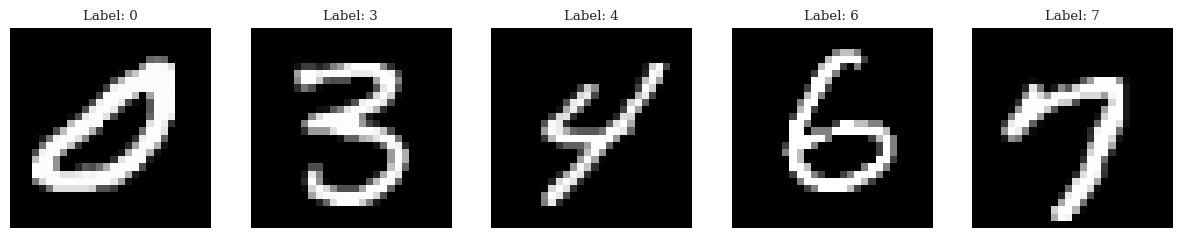

In [9]:
# Dispaly 5 images from the dataset, one from each class
np.random.seed(42)
num_images = 5
fig, ax = plt.subplots(1, num_images, figsize=(15, 3))
for i, label in enumerate(class_list):
    idx = np.random.choice(np.where(y==int(label))[0])
    ax[i].imshow(X[idx].reshape(28, 28), cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'Label: {label}')

### Learning optimal dictionaries for MNIST sparse coding

In [10]:
# Let's compute KMeans on the dataset
X = X.reshape(X.shape[0], -1)
K = exp_params['model']['K']
kmeans = KMeans(n_clusters=K, random_state=42, max_iter=1000, verbose=1).fit(X)
centres = kmeans.cluster_centers_

/n/home13/shubham/.conda/envs/representations/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 83245.2331410997.
Iteration 1, inertia 55582.696932468345.
Iteration 2, inertia 54946.16259778294.
Iteration 3, inertia 54717.2534215334.
Iteration 4, inertia 54629.88451984383.
Iteration 5, inertia 54616.38832044515.
Iteration 6, inertia 54613.74733547422.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 83144.27549404082.
Iteration 1, inertia 55464.17022845505.
Iteration 2, inertia 54736.90423647981.
Iteration 3, inertia 54554.79915980572.
Iteration 4, inertia 54499.27200678434.
Iteration 5, inertia 54456.7733053975.
Iteration 6, inertia 54449.471968244216.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 82765.89982314483.
Iteration 1, inertia 55383.38618332964.
Iteration 2, inertia 54681.180171266096.
Iteration 3, inertia 54502.23769893911.
Iteration 4, inertia 54445.35631644114.
Iteration 5, inertia 54430.46487389374.
Iteration 6, inertia 54421.103355789

In [11]:
centres.shape

(400, 784)

In [12]:
# Let's visualize the cluster centres via tsne plot of the data points and the cluster centres
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(np.vstack([X, centres]))
data_embedded = X_embedded[:-centres.shape[0]]
centres_embedded = X_embedded[-centres.shape[0]:]

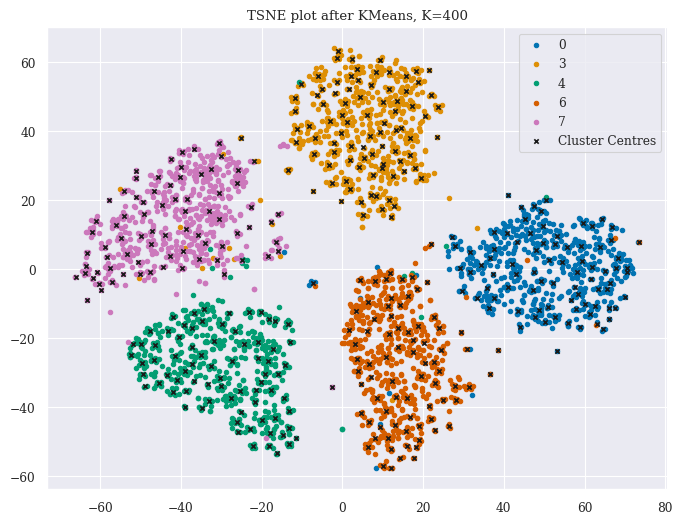

In [13]:
# Plot the data points and cluster centers and color the cluster centers according to the class. We also add a legend
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for i, label in enumerate(class_list):
    idx = np.where(y==int(label))[0]
    ax.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=label, s=10)
ax.scatter(centres_embedded[:, 0], centres_embedded[:, 1], label='Cluster Centres', marker='x', s=10, c='k')
ax.legend()
ax.set_title(f'TSNE plot after KMeans, K={K}')
fig.show()